# Naming game experiments in a simplified probabilistic environment

In this notebook we can simulate the alignment results we would obtain with the naming game for different probabilities of solving different type of goals.

The `scores` matrix contains the probability of solving a pair of goals from the point of view of one agent, should be read as $P(\text{solving my goal i, when other agent selected goal j}) = p_{i,j}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, product
from scipy.special import softmax
import torch.nn

In [3]:
plt.rc("font", family="serif")
plt.rc("xtick", labelsize="small")
plt.rc("ytick", labelsize="small")
plt.rc("legend", fontsize="small")
plt.rc("axes", labelsize="small")

# General settings

In [7]:
NUMBER_OF_LANDMARKS = 6
# Number of updates to the matrix
N_STEPS = 10_000
# Update step
DELTA = 1
# Exploration probability (0 is greedy but stil explores since there are negative updates for bad associations)
EGREEDY = 0.05

# Only cooperative goals

`scores0` is the probability matrix used by agent 0, `scores1` is the probability matrix for agent 1

In [8]:
# A basic probability matrix where the probability of solving aligned goals is 1, and different goals 0.3

scores = np.eye(NUMBER_OF_LANDMARKS)
P_DIFFERENT_GOALS = 0.3

for i in range(scores.shape[0]):
    for j in range(scores.shape[1]):
        if i != j:
            scores[i, j] = P_DIFFERENT_GOALS
n_goals = scores.shape[0]

scores0 = scores1 = scores

# Alternatively you can create the matrix entry by entry, and specify different matrices for each agent

# scores1 = np.array([
#     [0.8, 0, 0.1],
#     [0, 1, 0.2],
#     [0.7, 0.8, 0.9]
# ])

# scores0 = np.array([
#     [0.8, 0, 0.1],
#     [0.1, 1, 0],
#     [0.2, 0, 0.9]
# ])

## One naming matrix per agent

Same matrix is used when agent is leader and follower

In [9]:
# Alignment for all seeds
a0 = []
a1 = []

for s in range(10):
    np.random.seed(s)
    agent_0 = np.zeros_like(scores0)
    agent_1 = np.zeros_like(scores1)
    for i in range(N_STEPS):
        leader_goal_index = np.random.randint(0, n_goals)
        if np.random.random() < 0.5:
            # Agent 0 leader
            if np.random.random() < EGREEDY:
                leader_msg_index = np.random.choice(range(scores.shape[0]))
            else:
                leader_msg_index = np.argmax(agent_0[leader_goal_index])
            if np.random.random() < EGREEDY:
                follower_goal_index = np.random.choice(range(scores.shape[0]))
            else:
                follower_goal_index = np.argmax(agent_1[:, leader_msg_index])
            leader_reward = (
                np.random.random() < scores0[leader_goal_index, follower_goal_index]
            )
            follower_reward = (
                np.random.random() < scores1[follower_goal_index, leader_goal_index]
            )
            if leader_reward:
                agent_0[leader_goal_index, :] -= DELTA
                agent_0[leader_goal_index, leader_msg_index] += (
                    leader_reward + 1
                ) * DELTA
            else:
                agent_0[leader_goal_index, leader_msg_index] -= DELTA
            if follower_reward:
                agent_1[:, leader_msg_index] -= DELTA
                agent_1[follower_goal_index, leader_msg_index] += (
                    follower_reward + 1
                ) * DELTA
            else:
                agent_1[follower_goal_index, leader_msg_index] -= DELTA

        else:
            # Agent 1 leader
            if np.random.random() < EGREEDY:
                leader_msg_index = np.random.choice(range(scores.shape[0]))
            else:
                leader_msg_index = np.argmax(agent_1[leader_goal_index])
            if np.random.random() < EGREEDY:
                follower_goal_index = np.random.choice(range(scores.shape[0]))
            else:
                follower_goal_index = np.argmax(agent_0[:, leader_msg_index])
            leader_reward = (
                np.random.random() < scores1[leader_goal_index, follower_goal_index]
            )
            follower_reward = (
                np.random.random() < scores0[follower_goal_index, leader_goal_index]
            )
            if leader_reward:
                agent_1[leader_goal_index, :] -= DELTA
                agent_1[leader_goal_index, leader_msg_index] += (
                    leader_reward + 1
                ) * DELTA
            else:
                agent_1[leader_goal_index, leader_msg_index] -= DELTA
            if follower_reward:
                agent_0[:, leader_msg_index] -= DELTA
                agent_0[follower_goal_index, leader_msg_index] += (
                    follower_reward + 1
                ) * DELTA
            else:
                agent_0[follower_goal_index, leader_msg_index] -= DELTA

    alignment_0_leader = []
    for i in range(0, n_goals):
        msg = np.argmax(agent_0[i])
        j = np.argmax(agent_1[:, msg])
        alignment_0_leader.append(i == j)

    alignment_1_leader = []
    for i in range(0, n_goals):
        msg = np.argmax(agent_1[i])
        j = np.argmax(agent_0[:, msg])
        alignment_1_leader.append(i == j)

    a0.append(sum(alignment_0_leader) / len(alignment_0_leader))
    a1.append(sum(alignment_1_leader) / len(alignment_1_leader))

In [10]:
print(f"Alignment for agent 0: {np.mean(a0)}")
print(f"Alignment for agent 1: {np.mean(a1)}")

Alignment for agent 0: 1.0
Alignment for agent 1: 1.0


## Minimum competence for getting alignment

Analysing what's the minimum probability needed for alignment. We assume that the probability of solving aligned goals is p, and different goals 0


In [101]:
discount=1.
t=1.
EGREEDY=0.0
NUMBER_OF_LANDMARKS=3
N_STEPS = 1000
n_goals=NUMBER_OF_LANDMARKS
discount_b=1/n_goals

In [99]:
# Alignment for all seeds
a0_p = []
a1_p = []


probas = np.arange(0.1, 1.1, 0.1)
for p in probas:
    a0 = []
    a1 = []
    scores = (np.eye(NUMBER_OF_LANDMARKS)*t+np.ones((NUMBER_OF_LANDMARKS,NUMBER_OF_LANDMARKS))*(1-t)) * p 
    
    
    for s in range(3):
        np.random.seed(s)
        agent_0 = np.zeros_like(scores)
        agent_1 = np.zeros_like(scores)
        for i in range(N_STEPS):
            leader_goal_index = np.random.randint(0, scores.shape[0])
            if np.random.random() < 0.5:
                # Agent 0 leader
                if np.random.random() < EGREEDY:
                    leader_msg_index = np.random.choice(range(scores.shape[0]))
                else:
                    leader_msg_index = np.argmax(agent_0[leader_goal_index])
                if np.random.random() < EGREEDY:
                    follower_goal_index = np.random.choice(range(scores.shape[0]))
                else:
                    follower_goal_index = np.argmax(agent_1[:, leader_msg_index])
                leader_reward = (
                    np.random.random() < scores[leader_goal_index, follower_goal_index]
                )
                follower_reward = (
                    np.random.random() < scores[follower_goal_index, leader_goal_index]
                )
                if leader_reward:
                    agent_0[leader_goal_index, :] -= DELTA*discount_b
                    agent_0[leader_goal_index, leader_msg_index] += (
                        leader_reward + discount_b
                    ) * DELTA
                else:
                    agent_0[leader_goal_index, leader_msg_index] -= DELTA*discount
                if follower_reward:
                    agent_1[:, leader_msg_index] -= DELTA*discount_b
                    agent_1[follower_goal_index, leader_msg_index] += (
                        follower_reward +  discount_b
                    ) * DELTA
                else:
                    agent_1[follower_goal_index, leader_msg_index] -= DELTA*discount

            else:
                # Agent 1 leader
                if np.random.random() < EGREEDY:
                    leader_msg_index = np.random.choice(range(scores.shape[0]))
                else:
                    leader_msg_index = np.argmax(agent_1[leader_goal_index])
                if np.random.random() < EGREEDY:
                    follower_goal_index = np.random.choice(range(scores.shape[0]))
                else:
                    follower_goal_index = np.argmax(agent_0[:, leader_msg_index])
                leader_reward = (
                    np.random.random() < scores[leader_goal_index, follower_goal_index]
                )
                follower_reward = (
                    np.random.random() < scores[follower_goal_index, leader_goal_index]
                )
                if leader_reward:
                    agent_1[leader_goal_index, :] -= DELTA*discount_b
                    agent_1[leader_goal_index, leader_msg_index] += (
                        leader_reward + discount_b
                    ) * DELTA
                else:
                    agent_1[leader_goal_index, leader_msg_index] -= DELTA*discount
                if follower_reward:
                    agent_0[:, leader_msg_index] -= DELTA*discount_b
                    agent_0[follower_goal_index, leader_msg_index] += (
                        follower_reward  + discount_b
                    ) * DELTA
                else:
                    agent_0[follower_goal_index, leader_msg_index] -= DELTA*discount

        alignment_0_leader = []
        for i in range(0, n_goals):
            msg = np.argmax(agent_0[i])
            j = np.argmax(agent_1[:, msg])
            alignment_0_leader.append(i == j)

        alignment_1_leader = []
        for i in range(0, n_goals):
            msg = np.argmax(agent_1[i])
            j = np.argmax(agent_0[:, msg])
            alignment_1_leader.append(i == j)

        a0.append(sum(alignment_0_leader) / len(alignment_0_leader))
        a1.append(sum(alignment_1_leader) / len(alignment_1_leader))
    print(a0,a1)
    a0_p.append(a0)
    a1_p.append(a1)

[0.6666666666666666, 0.3333333333333333, 0.6666666666666666] [0.6666666666666666, 0.3333333333333333, 0.3333333333333333]
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333] [0.0, 0.3333333333333333, 0.3333333333333333]
[0.3333333333333333, 0.3333333333333333, 0.0] [0.0, 0.3333333333333333, 0.3333333333333333]
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333] [0.3333333333333333, 0.3333333333333333, 0.6666666666666666]
[0.3333333333333333, 0.6666666666666666, 1.0] [0.6666666666666666, 0.3333333333333333, 1.0]
[1.0, 1.0, 1.0] [1.0, 1.0, 1.0]
[1.0, 0.3333333333333333, 1.0] [1.0, 0.3333333333333333, 1.0]
[0.0, 0.3333333333333333, 0.6666666666666666] [0.0, 0.3333333333333333, 0.6666666666666666]
[0.3333333333333333, 0.3333333333333333, 0.6666666666666666] [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
[0.6666666666666666, 0.3333333333333333, 0.3333333333333333] [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


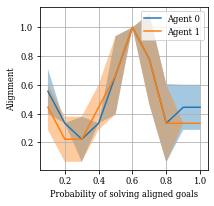

In [100]:
plt.figure(figsize=[3, 3])
plt.plot(probas, np.mean(a0_p, 1), label="Agent 0")
plt.fill_between(
    probas,
    np.mean(a0_p, 1) + np.std(a0_p, 1),
    np.mean(a0_p, 1) - np.std(a0_p, 1),
    alpha=0.4,
)

plt.plot(probas, np.mean(a1_p, 1), label="Agent 1")
plt.fill_between(
    probas,
    np.mean(a1_p, 1) + np.std(a1_p, 1),
    np.mean(a1_p, 1) - np.std(a1_p, 1),
    alpha=0.4,
)
plt.legend()
plt.xlabel("Probability of solving aligned goals")
plt.ylabel("Alignment")
plt.grid()

plt.savefig("alignment_vs_p.png", dpi=300, bbox_inches="tight", transparent=True)

## Two matrices per agent

One matrix is used when the agent is leader and a different one is used when the agent is a follower

In [69]:
# Alignment for all seeds
a0 = []
a1 = []

for s in range(10):
    np.random.seed(s)
    agent_0 = np.zeros_like(scores)
    agent_1 = np.zeros_like(scores)
    agent_0f = np.zeros_like(scores)
    agent_1f = np.zeros_like(scores)

    for i in range(N_STEPS):
        leader_goal_index = np.random.randint(0, n_goals)
        if np.random.random() < 0.5:
            # Agent 0 leader
            if np.random.random() < EGREEDY:
                leader_msg_index = np.random.choice(range(scores.shape[0]))
            else:
                leader_msg_index = np.argmax(agent_0[leader_goal_index])
            if np.random.random() < EGREEDY:
                follower_goal_index = np.random.choice(range(scores.shape[0]))
            else:
                follower_goal_index = np.argmax(agent_1f[leader_msg_index])
            leader_reward = (
                np.random.random() < scores0[leader_goal_index, follower_goal_index]
            )
            follower_reward = (
                np.random.random() < scores1[follower_goal_index, leader_goal_index]
            )
            if leader_reward:
                agent_0[leader_goal_index, :] -= DELTA
                agent_0[leader_goal_index, leader_msg_index] += (
                    leader_reward + 1
                ) * DELTA
            else:
                agent_0[leader_goal_index, leader_msg_index] -= DELTA
            if follower_reward:
                agent_1f[leader_msg_index] -= DELTA
                agent_1f[leader_msg_index, follower_goal_index] += (
                    follower_reward + 1
                ) * DELTA
            else:
                agent_1f[leader_msg_index, follower_goal_index] -= DELTA

        else:
            # Agent 1 leader
            if np.random.random() < EGREEDY:
                leader_msg_index = np.random.choice(range(scores.shape[0]))
            else:
                leader_msg_index = np.argmax(agent_1[leader_goal_index])
            if np.random.random() < EGREEDY:
                follower_goal_index = np.random.choice(range(scores.shape[0]))
            else:
                follower_goal_index = np.argmax(agent_0f[leader_msg_index])
            leader_reward = (
                np.random.random() < scores1[leader_goal_index, follower_goal_index]
            )
            follower_reward = (
                np.random.random() < scores0[follower_goal_index, leader_goal_index]
            )
            if leader_reward:
                agent_1[leader_goal_index, :] -= DELTA
                agent_1[leader_goal_index, leader_msg_index] += (
                    leader_reward + 1
                ) * DELTA
            else:
                agent_1[leader_goal_index, leader_msg_index] -= DELTA
            if follower_reward:
                agent_0f[leader_msg_index] -= DELTA
                agent_0f[leader_msg_index, follower_goal_index] += (
                    follower_reward + 1
                ) * DELTA
            else:
                agent_0f[leader_msg_index, follower_goal_index] -= DELTA

    alignment_0_leader = []
    for i in range(0, n_goals):
        msg = np.argmax(agent_0[i])
        j = np.argmax(agent_1f[msg])
        alignment_0_leader.append(i == j)

    alignment_1_leader = []
    for i in range(0, n_goals):
        msg = np.argmax(agent_1[i])
        j = np.argmax(agent_0f[msg])
        alignment_1_leader.append(i == j)

    a0.append(sum(alignment_0_leader) / len(alignment_0_leader))
    a1.append(sum(alignment_1_leader) / len(alignment_1_leader))

In [70]:
print(f"Alignment for agent 0: {np.mean(a0)}")
print(f"Alignment for agent 1: {np.mean(a1)}")

Alignment for agent 0: 0.8
Alignment for agent 1: 0.8666666666666668


# All goals

Now we consder all goals both individual and cooperative, we define the matrix for the different type of goals by setting the following constants

We consider variable reward multiplier for cooperative goals, this is needed to incentivize follower's picking cooperative goals.

In [27]:
# Probability of success when solving an individual goal
P_INDIVIDUAL = 1.0
# Probability of success when solving a collective goal, and the other agent is following the same goal
P_COLLECTIVE_SAME = 1.0
# Probability of success when solving a collective goal, and the other agent is solving an individual but compatible goal (e.g 101 and 001)
P_COLLECTIVE_INDIVIDUAL_COMPAT = 0.0
# Probability of success when solving a collective goal, and the other agent is solving another "compatible" collective goal (e.g 101 and 011)
P_COLLECTIVE_COLLECTIVE_COMPAT = 0.0

In [28]:
individual_goals = np.eye(NUMBER_OF_LANDMARKS, dtype=np.uint8).tolist()
collective_goals = np.array(list(combinations(individual_goals, 2))).sum(1).tolist()
goal_space = individual_goals + collective_goals
n_goals = len(goal_space)
n_individual = len(individual_goals)

In [29]:
n_goals**2

36

In [30]:
# scores(own_goal, other_goal) = probability of reward for that agent
scores = np.zeros((n_goals, n_goals))
# setting individual goals scores
scores[:n_individual, :] = P_INDIVIDUAL
# setting for collective goals
for n in range(n_individual, n_goals):
    # compatible collective goals
    for i in range(n_individual, n_goals):
        if np.bitwise_or.reduce([goal_space[n], goal_space[i]]).sum() == 3:
            scores[n, i] = P_COLLECTIVE_COLLECTIVE_COMPAT
    # compatible collective + individual goals
    for i in range(n_individual):
        if np.bitwise_or.reduce([goal_space[n], goal_space[i]]).sum() == 2:
            scores[n, i] = P_COLLECTIVE_INDIVIDUAL_COMPAT
    # same collective goals
    scores[n, n] = P_COLLECTIVE_SAME

In [31]:
scores

array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [32]:
a0_all = []
a1_all = []
cooperative_factors = range(1, 100, 20)
for b in cooperative_factors:
    # # Double matrix full communication naming game double matrices
    a0 = []
    a1 = []
    for s in range(5):
        np.random.seed(s)
        agent_0 = np.zeros_like(scores)
        agent_1 = np.zeros_like(scores)

        agent_0f = np.zeros_like(scores)
        agent_1f = np.zeros_like(scores)

        rewards_0 = []
        rewards_1 = []
        alignment = []

        EGREEDY = 0.15
        EGREEDY = 0.05

        for i in range(N_STEPS):
            leader_goal_index = np.random.randint(0, n_goals)
            if np.random.random() < 0.5:
                # Agent 0 leader
                # egreedy
                if EGREEDY:
                    if np.random.random() < EGREEDY:
                        leader_msg_index = np.random.choice(range(scores.shape[0]))
                    else:
                        leader_msg_index = np.argmax(agent_0[leader_goal_index])
                    if np.random.random() < EGREEDY:
                        follower_goal_index = np.random.choice(range(scores.shape[0]))
                    else:
                        follower_goal_index = np.argmax(agent_1f[leader_msg_index])
                else:
                    leader_scores = torch.nn.functional.softmax(
                        torch.Tensor(agent_0[leader_goal_index])
                    ).numpy()
                    leader_scores /= sum(leader_scores)
                    leader_msg_index = np.random.choice(
                        range(scores.shape[0]), p=leader_scores
                    )
                    follower_scores = torch.nn.functional.softmax(
                        torch.Tensor(agent_1f[leader_msg_index])
                    ).numpy()
                    follower_scores /= sum(follower_scores)
                    follower_goal_index = np.random.choice(
                        range(scores.shape[0]), p=follower_scores
                    )
                leader_reward = (
                    np.random.random() < scores[leader_goal_index, follower_goal_index]
                )
                follower_reward = (
                    np.random.random() < scores[follower_goal_index, leader_goal_index]
                )
                # Collective reward adjustment
                if leader_goal_index > n_individual - 1:
                    leader_reward *= b
                if follower_goal_index > n_individual - 1:
                    follower_reward *= b
                rewards_0.append(leader_reward)
                rewards_1.append(follower_reward)
                if leader_reward:
                    agent_0[leader_goal_index, :] -= DELTA
                    agent_0[leader_goal_index, leader_msg_index] += (
                        leader_reward + 1
                    ) * DELTA
                else:
                    agent_0[leader_goal_index, leader_msg_index] -= DELTA
                if follower_reward:
                    agent_1f[leader_msg_index, :] -= DELTA
                    agent_1f[leader_msg_index, follower_goal_index] += (
                        follower_reward + 1
                    ) * DELTA
                else:
                    agent_1f[leader_msg_index, follower_goal_index] -= DELTA

            else:
                # Agent 1 leader
                if EGREEDY:
                    if np.random.random() < EGREEDY:
                        leader_msg_index = np.random.choice(range(scores.shape[0]))
                    else:
                        leader_msg_index = np.argmax(agent_1[leader_goal_index])
                    if np.random.random() < EGREEDY:
                        follower_goal_index = np.random.choice(range(scores.shape[0]))
                    else:
                        follower_goal_index = np.argmax(agent_0f[leader_msg_index])
                else:
                    leader_scores = torch.nn.functional.softmax(
                        torch.Tensor(agent_1[leader_goal_index])
                    ).numpy()
                    leader_scores /= sum(leader_scores)
                    leader_msg_index = np.random.choice(
                        range(scores.shape[0]), p=leader_scores
                    )
                    follower_scores = torch.nn.functional.softmax(
                        torch.Tensor(agent_0f[leader_msg_index])
                    ).numpy()
                    follower_scores /= sum(follower_scores)
                    follower_goal_index = np.random.choice(
                        range(scores.shape[0]), p=follower_scores
                    )
                leader_reward = (
                    np.random.random() < scores[leader_goal_index, follower_goal_index]
                )
                follower_reward = (
                    np.random.random() < scores[follower_goal_index, leader_goal_index]
                )
                # Collective reward adjustment
                if leader_goal_index > n_individual - 1:
                    leader_reward *= b
                if follower_goal_index > n_individual - 1:
                    follower_reward *= b
                rewards_1.append(leader_reward)
                rewards_0.append(follower_reward)
                if leader_reward:
                    agent_1[leader_goal_index, :] -= DELTA
                    agent_1[leader_goal_index, leader_msg_index] += (
                        leader_reward + 1
                    ) * DELTA
                else:
                    agent_1[leader_goal_index, leader_msg_index] -= DELTA
                if follower_reward:
                    agent_0f[leader_msg_index, :] -= DELTA
                    agent_0f[leader_msg_index, follower_goal_index] += (
                        follower_reward + 1
                    ) * DELTA
                else:
                    agent_0f[leader_msg_index, follower_goal_index] -= DELTA

            if leader_goal_index > n_individual - 1:
                alignment.append(leader_goal_index == follower_goal_index)

        alignment_0_leader = []
        for i in range(n_individual, n_goals):
            msg = np.argmax(agent_0[i])
            j = np.argmax(agent_1f[msg])
            alignment_0_leader.append(i == j)

        alignment_1_leader = []
        for i in range(n_individual, n_goals):
            msg = np.argmax(agent_1[i])
            j = np.argmax(agent_0f[msg])
            alignment_1_leader.append(i == j)

        a0.append(sum(alignment_0_leader) / len(alignment_0_leader))
        a1.append(sum(alignment_1_leader) / len(alignment_1_leader))
    a0_all.append(a0)
    a1_all.append(a1)

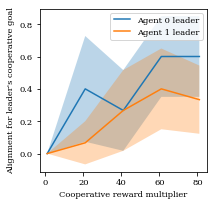

In [34]:
plt.figure(figsize=[3, 3])
plt.plot(cooperative_factors, np.mean(a0_all, axis=1), label="Agent 0 leader")
plt.fill_between(
    cooperative_factors,
    np.mean(a0_all, axis=1) - np.std(a0_all, axis=1),
    np.mean(a0_all, axis=1) + np.std(a0_all, axis=1),
    alpha=0.3,
)
plt.legend()
plt.plot(cooperative_factors, np.mean(a1_all, axis=1), label="Agent 1 leader")
plt.fill_between(
    cooperative_factors,
    np.mean(a1_all, axis=1) - np.std(a1_all, axis=1),
    np.mean(a1_all, axis=1) + np.std(a1_all, axis=1),
    alpha=0.3,
)
plt.legend()
plt.grid()
plt.xlabel("Cooperative reward multiplier")
plt.ylabel("Alignment for leader's cooperative goal")

plt.grid()

plt.savefig(
    "alignment_vs_coop_reward.png", dpi=300, bbox_inches="tight", transparent=True
)